In [2]:
import torch
from torch import nn
import torchaudio
import soundfile
torch.__version__

C:\Users\Vishwas\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.13.0+cpu'

In [3]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
from pathlib import Path
audio_path = Path("AUDIO/")

In [5]:
import os
def walk_through_dir(dir_path):
  
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} audios in '{dirpath}'.")

In [6]:
walk_through_dir(audio_path)

There are 3 directories and 0 audios in 'AUDIO'.
There are 0 directories and 14 audios in 'AUDIO\input'.
There are 2 directories and 0 audios in 'AUDIO\test'.
There are 0 directories and 50 audios in 'AUDIO\test\female'.
There are 0 directories and 52 audios in 'AUDIO\test\male'.
There are 2 directories and 0 audios in 'AUDIO\train'.
There are 0 directories and 120 audios in 'AUDIO\train\female'.
There are 0 directories and 124 audios in 'AUDIO\train\male'.


In [7]:
# Setup train and testing paths
train_dir = audio_path / "train"
test_dir = audio_path / "test"

train_dir, test_dir

(WindowsPath('AUDIO/train'), WindowsPath('AUDIO/test'))

In [8]:
# Setup path for target directory
import os
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(audio_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: AUDIO\train
Class names found: ['female', 'male']


In [9]:
# Make function to find classes in target directory
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Crearte a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [10]:
find_classes(train_dir)

(['female', 'male'], {'female': 0, 'male': 1})

In [11]:
from torch.utils.data import Dataset
import torchaudio
import soundfile
from typing import Tuple, Dict, List
import torchaudio
import torch
import pathlib
import random

torch.manual_seed(42)
# 1. Subclass torch.utils.data.Dataset
class AudioFolderCustom(Dataset):
    
    
    def __init__(self, targ_dir, transformation,target_sample_rate,num_samples,device) -> None:
        
        # 3. Create class attributes
        
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.wav"))
        #print(self.paths)
        self.device = device
        # Setup transforms
        self.transform = transformation.to(self.device)
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    # 5. Overwrite the __len__() method
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method 
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        signal, sr = torchaudio.load(self.paths[index])
        signal = signal.to(self.device)
        signal = random.uniform(2,3)*signal
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transform(signal)
        class_name  = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name]
        return signal, class_idx
    
    def _resample_if_necessary(self, signal, sr):
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal
    #channel to 1
    def _mix_down_if_necessary(self, signal):
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal
    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal
    

In [12]:
SAMPLE_RATE = 22050*3
NUM_SAMPLES = 22050*3

In [13]:
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=512,
        n_mels=80
    )

In [15]:
train_data_custom = AudioFolderCustom(train_dir, 
                                      mel_spectrogram,SAMPLE_RATE,NUM_SAMPLES,device)
test_data_custom = AudioFolderCustom(test_dir, 
                                     mel_spectrogram,SAMPLE_RATE,NUM_SAMPLES,device)
train_data_custom, test_data_custom

(<__main__.AudioFolderCustom at 0x18a94aef340>,
 <__main__.AudioFolderCustom at 0x18af8108940>)

In [15]:
train_data_custom.classes

['female', 'male']

In [16]:
train_data_custom.class_to_idx

{'female': 0, 'male': 1}

In [17]:
print(test_data_custom[0],train_data_custom[0])

(tensor([[[4.7248e+00, 2.1508e-03, 1.5594e-02,  ..., 1.4085e-04,
          2.4772e-05, 5.0970e-05],
         [2.5056e+01, 1.1405e-02, 8.2697e-02,  ..., 7.4693e-04,
          1.3136e-04, 2.7029e-04],
         [2.6981e+01, 3.0922e-01, 6.5375e-01,  ..., 3.2839e-03,
          2.0076e-03, 3.5266e-04],
         ...,
         [6.1151e-03, 5.9384e-07, 7.5762e-07,  ..., 3.4950e-10,
          1.7065e-10, 1.1816e-08],
         [6.2729e-03, 6.7864e-07, 1.1964e-06,  ..., 6.9198e-10,
          5.9133e-10, 1.1520e-08],
         [6.0788e-03, 6.1461e-08, 2.1745e-07,  ..., 7.4369e-11,
          6.5892e-11, 1.1119e-08]]]), 0) (tensor([[[3.8457e-02, 5.8976e-03, 4.7658e-02,  ..., 8.4874e-03,
          1.3708e-02, 1.4897e-03],
         [2.0394e-01, 3.1275e-02, 2.5273e-01,  ..., 4.5008e-02,
          7.2694e-02, 7.8998e-03],
         [7.1196e-04, 1.0215e-01, 1.4342e-01,  ..., 5.0089e-03,
          1.7869e-03, 3.5336e-02],
         ...,
         [2.4455e-03, 1.0294e-05, 2.6047e-06,  ..., 1.4802e-07,
         

In [18]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=64, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading?
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=64, 
                                    num_workers=0, 
                                    shuffle=True) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x20fee11bf40>,
 <torch.utils.data.dataloader.DataLoader at 0x20fee11b1c0>)

In [19]:
print(f"There are {len(train_data_custom)} samples in the dataset.")
signal, label= train_data_custom[5]
print("signal:",signal,"signal shape:",signal.shape)
print("label",label,train_data_custom.classes[label])

There are 244 samples in the dataset.
signal: tensor([[[7.4371e-03, 7.5011e-03, 6.0895e-01,  ..., 1.1988e-02,
          7.2063e-03, 1.3367e-02],
         [3.9439e-02, 3.9778e-02, 3.2293e+00,  ..., 6.3573e-02,
          3.8215e-02, 7.0886e-02],
         [1.4214e-01, 1.2397e-01, 7.5224e+00,  ..., 2.4372e-02,
          2.9462e-04, 3.0268e-04],
         ...,
         [2.4241e-04, 5.0115e-07, 1.2686e-06,  ..., 8.5612e-07,
          1.1237e-06, 4.5896e-05],
         [2.3667e-04, 7.7138e-07, 1.9877e-06,  ..., 1.1023e-06,
          1.1035e-06, 3.8211e-05],
         [2.3666e-04, 1.1477e-07, 1.7577e-07,  ..., 2.2709e-07,
          3.3115e-07, 3.5234e-05]]]) signal shape: torch.Size([1, 80, 130])
label 0 female


In [20]:
# Get audio and label from custom DataLoader
audio_custom, label_custom = next(iter(train_dataloader_custom))


print(f"Audio shape: {audio_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Audio shape: torch.Size([64, 1, 80, 130]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([64])


In [21]:
from torch import nn
from torchsummary import summary


class GenderDetect_V01(nn.Module):

    def __init__(self,input_shape: int,output_shape: int):
        super().__init__()
        # 7 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=30,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=30,
                out_channels=60,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=60,
                out_channels=120,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=120,
                out_channels=240,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels=240,
                out_channels=480,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(
                in_channels=480,
                out_channels=960,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(
                in_channels=960,
                out_channels=1920,
                kernel_size=2,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(1920*3*3, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)
        #print(x.shape)
        x = self.conv4(x)
        #print(x.shape)
        x = self.conv5(x)
        #print(x.shape)
        x = self.conv6(x)
        #print(x.shape)
        x = self.conv7(x)
        #print(x.shape)
        x = self.flatten(x)
        #print(x.shape)
        x = self.linear(x)
        return x


In [23]:
torch.manual_seed(42)
model_0 = GenderDetect_V01(input_shape=1, 
                  output_shape=len(train_data_custom.classes)).to(device)
model_0

GenderDetect_V01(
  (conv1): Sequential(
    (0): Conv2d(1, 30, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(30, 60, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(60, 120, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(120, 240, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(240, 480, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, d

In [24]:
#!pip install torchinfo
import torchinfo
from torchinfo import summary
summary(model_0, input_size=[64, 1, 80, 130])

Layer (type:depth-idx)                   Output Shape              Param #
GenderDetect_V01                         [64, 2]                   --
├─Sequential: 1-1                        [64, 30, 41, 66]          --
│    └─Conv2d: 2-1                       [64, 30, 83, 133]         150
│    └─ReLU: 2-2                         [64, 30, 83, 133]         --
│    └─MaxPool2d: 2-3                    [64, 30, 41, 66]          --
├─Sequential: 1-2                        [64, 60, 22, 34]          --
│    └─Conv2d: 2-4                       [64, 60, 44, 69]          7,260
│    └─ReLU: 2-5                         [64, 60, 44, 69]          --
│    └─MaxPool2d: 2-6                    [64, 60, 22, 34]          --
├─Sequential: 1-3                        [64, 120, 12, 18]         --
│    └─Conv2d: 2-7                       [64, 120, 25, 37]         28,920
│    └─ReLU: 2-8                         [64, 120, 25, 37]         --
│    └─MaxPool2d: 2-9                    [64, 120, 12, 18]         --
├─Seque

In [25]:
def train_step(scheduler,model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    #scheduler.step(train_loss)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [26]:
def test_step(scheduler,model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    scheduler.step(test_loss)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [27]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(scheduler,model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(scheduler,model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(scheduler,model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [36]:
def run():
    # Set random seeds
    torch.manual_seed(42) 
    torch.cuda.manual_seed(42)

    # Set number of epochs
    NUM_EPOCHS = 100

    # Recreate an instance of GenderDetect_V01
    model_0 = GenderDetect_V01(input_shape=1,
                      output_shape=len(train_data_custom.classes)).to(device)

    # Setup loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1,patience = 8,verbose = True)
    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Train model_0 
    model_0_results = train(scheduler,model=model_0, 
                            train_dataloader=train_dataloader_custom,
                            test_dataloader=test_dataloader_custom,
                            optimizer=optimizer,
                            loss_fn=loss_fn, 
                            epochs=NUM_EPOCHS)

    # End the timer and print out how long it took
    end_time = timer()
    print(f"Total training time: {end_time-start_time:.3f} seconds")
    return model_0_results

In [37]:
model_0_results = run()

  1%|▊                                                                               | 1/100 [00:38<1:03:43, 38.62s/it]

Epoch: 1 | train_loss: 219.1967 | train_acc: 0.4991 | test_loss: 0.9261 | test_acc: 0.5132


  2%|█▌                                                                              | 2/100 [01:16<1:02:27, 38.24s/it]

Epoch: 2 | train_loss: 1.1266 | train_acc: 0.5033 | test_loss: 0.6338 | test_acc: 0.5238


  3%|██▍                                                                             | 3/100 [01:56<1:02:55, 38.92s/it]

Epoch: 3 | train_loss: 0.7026 | train_acc: 0.5204 | test_loss: 0.6899 | test_acc: 0.4560


  4%|███▏                                                                            | 4/100 [02:33<1:00:58, 38.11s/it]

Epoch: 4 | train_loss: 0.6830 | train_acc: 0.5303 | test_loss: 0.7116 | test_acc: 0.5366


  5%|████                                                                              | 5/100 [03:10<59:55, 37.84s/it]

Epoch: 5 | train_loss: 0.6325 | train_acc: 0.5895 | test_loss: 0.6188 | test_acc: 0.6205


  6%|████▊                                                                           | 6/100 [03:52<1:01:16, 39.11s/it]

Epoch: 6 | train_loss: 0.6040 | train_acc: 0.6283 | test_loss: 0.6695 | test_acc: 0.6912


  7%|█████▋                                                                            | 7/100 [04:28<59:18, 38.27s/it]

Epoch: 7 | train_loss: 0.5561 | train_acc: 0.6448 | test_loss: 0.9396 | test_acc: 0.5362


  8%|██████▌                                                                           | 8/100 [05:05<58:06, 37.90s/it]

Epoch: 8 | train_loss: 0.5478 | train_acc: 0.6556 | test_loss: 0.6449 | test_acc: 0.6752


  9%|███████▍                                                                          | 9/100 [05:44<57:42, 38.05s/it]

Epoch: 9 | train_loss: 0.5286 | train_acc: 0.6797 | test_loss: 0.6374 | test_acc: 0.7015


 10%|████████                                                                         | 10/100 [06:28<59:55, 39.95s/it]

Epoch: 10 | train_loss: 0.4756 | train_acc: 0.7091 | test_loss: 0.7920 | test_acc: 0.6521


 11%|████████▉                                                                        | 11/100 [07:07<58:48, 39.65s/it]

Epoch: 11 | train_loss: 0.4400 | train_acc: 0.7341 | test_loss: 0.6707 | test_acc: 0.7225


 12%|█████████▋                                                                       | 12/100 [07:46<58:07, 39.63s/it]

Epoch: 12 | train_loss: 0.3939 | train_acc: 0.7800 | test_loss: 0.8779 | test_acc: 0.6180


 13%|██████████▌                                                                      | 13/100 [08:25<57:13, 39.46s/it]

Epoch: 13 | train_loss: 0.3416 | train_acc: 0.8194 | test_loss: 0.7757 | test_acc: 0.7488


 14%|███████████▎                                                                     | 14/100 [09:03<55:41, 38.86s/it]

Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 14 | train_loss: 0.3025 | train_acc: 0.8278 | test_loss: 1.0525 | test_acc: 0.6863


 15%|████████████▏                                                                    | 15/100 [09:40<54:21, 38.38s/it]

Epoch: 15 | train_loss: 0.3676 | train_acc: 0.7945 | test_loss: 0.7470 | test_acc: 0.7541


 16%|████████████▉                                                                    | 16/100 [10:18<53:34, 38.27s/it]

Epoch: 16 | train_loss: 0.2628 | train_acc: 0.8900 | test_loss: 1.1783 | test_acc: 0.6443


 17%|█████████████▊                                                                   | 17/100 [10:57<53:07, 38.41s/it]

Epoch: 17 | train_loss: 0.2962 | train_acc: 0.8311 | test_loss: 1.2246 | test_acc: 0.6308


 18%|██████████████▌                                                                  | 18/100 [11:39<53:55, 39.45s/it]

Epoch: 18 | train_loss: 0.2612 | train_acc: 0.8645 | test_loss: 0.8468 | test_acc: 0.6990


 19%|███████████████▍                                                                 | 19/100 [12:19<53:29, 39.62s/it]

Epoch: 19 | train_loss: 0.2493 | train_acc: 0.9017 | test_loss: 0.7446 | test_acc: 0.7463


 20%|████████████████▏                                                                | 20/100 [12:57<52:12, 39.15s/it]

Epoch: 20 | train_loss: 0.2502 | train_acc: 0.8978 | test_loss: 0.8389 | test_acc: 0.7225


 21%|█████████████████                                                                | 21/100 [13:36<51:24, 39.05s/it]

Epoch: 21 | train_loss: 0.2467 | train_acc: 0.9105 | test_loss: 0.8711 | test_acc: 0.7356


 22%|█████████████████▊                                                               | 22/100 [14:13<49:55, 38.40s/it]

Epoch: 22 | train_loss: 0.2323 | train_acc: 0.9123 | test_loss: 0.7999 | test_acc: 0.7697


 23%|██████████████████▋                                                              | 23/100 [14:51<49:22, 38.48s/it]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 23 | train_loss: 0.2259 | train_acc: 0.9192 | test_loss: 0.8270 | test_acc: 0.7278


 24%|███████████████████▍                                                             | 24/100 [15:30<48:46, 38.51s/it]

Epoch: 24 | train_loss: 0.2251 | train_acc: 0.9029 | test_loss: 0.9099 | test_acc: 0.6986


 25%|████████████████████▎                                                            | 25/100 [16:08<48:02, 38.44s/it]

Epoch: 25 | train_loss: 0.2246 | train_acc: 0.9047 | test_loss: 0.8510 | test_acc: 0.7327


 26%|█████████████████████                                                            | 26/100 [16:47<47:24, 38.44s/it]

Epoch: 26 | train_loss: 0.2306 | train_acc: 0.9026 | test_loss: 0.8938 | test_acc: 0.7648


 27%|█████████████████████▊                                                           | 27/100 [17:26<47:16, 38.86s/it]

Epoch: 27 | train_loss: 0.2266 | train_acc: 0.9017 | test_loss: 0.7939 | test_acc: 0.7566


 28%|██████████████████████▋                                                          | 28/100 [18:03<45:56, 38.29s/it]

Epoch: 28 | train_loss: 0.2267 | train_acc: 0.9183 | test_loss: 0.8342 | test_acc: 0.7619


 29%|███████████████████████▍                                                         | 29/100 [18:41<44:58, 38.01s/it]

Epoch: 29 | train_loss: 0.2214 | train_acc: 0.9165 | test_loss: 0.6995 | test_acc: 0.7780


 30%|████████████████████████▎                                                        | 30/100 [19:18<43:59, 37.70s/it]

Epoch: 30 | train_loss: 0.2189 | train_acc: 0.9201 | test_loss: 0.7309 | test_acc: 0.7619


 31%|█████████████████████████                                                        | 31/100 [19:55<43:12, 37.58s/it]

Epoch: 31 | train_loss: 0.2181 | train_acc: 0.9210 | test_loss: 0.7843 | test_acc: 0.7541


 32%|█████████████████████████▉                                                       | 32/100 [20:34<43:02, 37.98s/it]

Epoch 00032: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 32 | train_loss: 0.2160 | train_acc: 0.9084 | test_loss: 0.8312 | test_acc: 0.7327


 33%|██████████████████████████▋                                                      | 33/100 [21:12<42:24, 37.97s/it]

Epoch: 33 | train_loss: 0.2206 | train_acc: 0.9075 | test_loss: 0.8797 | test_acc: 0.7726


 34%|███████████████████████████▌                                                     | 34/100 [21:49<41:21, 37.59s/it]

Epoch: 34 | train_loss: 0.2198 | train_acc: 0.9078 | test_loss: 0.7908 | test_acc: 0.7595


 35%|████████████████████████████▎                                                    | 35/100 [22:26<40:45, 37.62s/it]

Epoch: 35 | train_loss: 0.2195 | train_acc: 0.9105 | test_loss: 0.8547 | test_acc: 0.7381


 36%|█████████████████████████████▏                                                   | 36/100 [23:04<40:18, 37.79s/it]

Epoch: 36 | train_loss: 0.2193 | train_acc: 0.9078 | test_loss: 0.8547 | test_acc: 0.7459


 37%|█████████████████████████████▉                                                   | 37/100 [23:43<39:52, 37.97s/it]

Epoch: 37 | train_loss: 0.2231 | train_acc: 0.9126 | test_loss: 0.8873 | test_acc: 0.7356


 38%|██████████████████████████████▊                                                  | 38/100 [24:21<39:26, 38.16s/it]

Epoch: 38 | train_loss: 0.2224 | train_acc: 0.9135 | test_loss: 0.8303 | test_acc: 0.7196


 39%|███████████████████████████████▌                                                 | 39/100 [25:00<38:54, 38.27s/it]

Epoch: 39 | train_loss: 0.2239 | train_acc: 0.9075 | test_loss: 0.8028 | test_acc: 0.7459


 40%|████████████████████████████████▍                                                | 40/100 [25:38<38:21, 38.35s/it]

Epoch: 40 | train_loss: 0.2193 | train_acc: 0.9135 | test_loss: 0.8674 | test_acc: 0.7488


 41%|█████████████████████████████████▏                                               | 41/100 [26:16<37:35, 38.23s/it]

Epoch 00041: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 41 | train_loss: 0.2222 | train_acc: 0.9017 | test_loss: 0.7522 | test_acc: 0.7488


 42%|██████████████████████████████████                                               | 42/100 [26:55<36:57, 38.23s/it]

Epoch: 42 | train_loss: 0.2232 | train_acc: 0.9192 | test_loss: 0.8778 | test_acc: 0.7488


 43%|██████████████████████████████████▊                                              | 43/100 [27:32<36:03, 37.96s/it]

Epoch: 43 | train_loss: 0.2204 | train_acc: 0.9183 | test_loss: 0.6693 | test_acc: 0.7619


 44%|███████████████████████████████████▋                                             | 44/100 [28:14<36:30, 39.12s/it]

Epoch: 44 | train_loss: 0.2239 | train_acc: 0.9183 | test_loss: 0.7496 | test_acc: 0.7673


 45%|████████████████████████████████████▍                                            | 45/100 [28:54<36:10, 39.46s/it]

Epoch: 45 | train_loss: 0.2227 | train_acc: 0.9144 | test_loss: 0.8692 | test_acc: 0.7356


 46%|█████████████████████████████████████▎                                           | 46/100 [29:33<35:29, 39.43s/it]

Epoch: 46 | train_loss: 0.2199 | train_acc: 0.9123 | test_loss: 0.7711 | test_acc: 0.7751


 47%|██████████████████████████████████████                                           | 47/100 [30:12<34:30, 39.07s/it]

Epoch: 47 | train_loss: 0.2190 | train_acc: 0.9008 | test_loss: 0.8940 | test_acc: 0.7434


 48%|██████████████████████████████████████▉                                          | 48/100 [30:51<33:59, 39.21s/it]

Epoch: 48 | train_loss: 0.2204 | train_acc: 0.9008 | test_loss: 0.7565 | test_acc: 0.7858


 49%|███████████████████████████████████████▋                                         | 49/100 [31:30<33:15, 39.13s/it]

Epoch: 49 | train_loss: 0.2213 | train_acc: 0.9069 | test_loss: 0.8039 | test_acc: 0.7459


 50%|████████████████████████████████████████▌                                        | 50/100 [32:08<32:24, 38.89s/it]

Epoch 00050: reducing learning rate of group 0 to 1.0000e-08.
Epoch: 50 | train_loss: 0.2145 | train_acc: 0.9144 | test_loss: 0.8099 | test_acc: 0.7755


 51%|█████████████████████████████████████████▎                                       | 51/100 [32:48<31:54, 39.07s/it]

Epoch: 51 | train_loss: 0.2204 | train_acc: 0.9222 | test_loss: 0.8535 | test_acc: 0.7488


 52%|██████████████████████████████████████████                                       | 52/100 [33:27<31:16, 39.10s/it]

Epoch: 52 | train_loss: 0.2184 | train_acc: 0.9056 | test_loss: 0.7850 | test_acc: 0.7673


 53%|██████████████████████████████████████████▉                                      | 53/100 [34:05<30:26, 38.86s/it]

Epoch: 53 | train_loss: 0.2168 | train_acc: 0.9192 | test_loss: 0.7796 | test_acc: 0.7566


 54%|███████████████████████████████████████████▋                                     | 54/100 [34:44<29:42, 38.76s/it]

Epoch: 54 | train_loss: 0.2196 | train_acc: 0.9135 | test_loss: 0.8701 | test_acc: 0.7249


 55%|████████████████████████████████████████████▌                                    | 55/100 [35:21<28:43, 38.31s/it]

Epoch: 55 | train_loss: 0.2149 | train_acc: 0.9231 | test_loss: 0.7392 | test_acc: 0.7566


 56%|█████████████████████████████████████████████▎                                   | 56/100 [36:01<28:21, 38.68s/it]

Epoch: 56 | train_loss: 0.2200 | train_acc: 0.9105 | test_loss: 0.9308 | test_acc: 0.7673


 57%|██████████████████████████████████████████████▏                                  | 57/100 [36:40<27:54, 38.93s/it]

Epoch: 57 | train_loss: 0.2214 | train_acc: 0.9123 | test_loss: 0.9046 | test_acc: 0.7434


 58%|██████████████████████████████████████████████▉                                  | 58/100 [37:20<27:21, 39.08s/it]

Epoch: 58 | train_loss: 0.2195 | train_acc: 0.9135 | test_loss: 0.8205 | test_acc: 0.7327


 59%|███████████████████████████████████████████████▊                                 | 59/100 [37:59<26:43, 39.11s/it]

Epoch: 59 | train_loss: 0.2197 | train_acc: 0.9135 | test_loss: 0.8389 | test_acc: 0.7220


 60%|████████████████████████████████████████████████▌                                | 60/100 [38:38<26:06, 39.16s/it]

Epoch: 60 | train_loss: 0.2156 | train_acc: 0.9135 | test_loss: 0.7785 | test_acc: 0.7595


 61%|█████████████████████████████████████████████████▍                               | 61/100 [39:17<25:24, 39.10s/it]

Epoch: 61 | train_loss: 0.2207 | train_acc: 0.9105 | test_loss: 0.8658 | test_acc: 0.7590


 62%|██████████████████████████████████████████████████▏                              | 62/100 [39:56<24:46, 39.12s/it]

Epoch: 62 | train_loss: 0.2201 | train_acc: 0.9201 | test_loss: 0.9153 | test_acc: 0.7619


 63%|███████████████████████████████████████████████████                              | 63/100 [40:35<24:02, 38.98s/it]

Epoch: 63 | train_loss: 0.2175 | train_acc: 0.9240 | test_loss: 0.7906 | test_acc: 0.7512


 64%|███████████████████████████████████████████████████▊                             | 64/100 [41:14<23:23, 38.98s/it]

Epoch: 64 | train_loss: 0.2247 | train_acc: 0.9026 | test_loss: 0.7786 | test_acc: 0.7541


 65%|████████████████████████████████████████████████████▋                            | 65/100 [41:53<22:40, 38.87s/it]

Epoch: 65 | train_loss: 0.2196 | train_acc: 0.9117 | test_loss: 0.7782 | test_acc: 0.7512


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [42:31<21:52, 38.60s/it]

Epoch: 66 | train_loss: 0.2196 | train_acc: 0.9162 | test_loss: 0.7739 | test_acc: 0.7434


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [43:09<21:13, 38.59s/it]

Epoch: 67 | train_loss: 0.2250 | train_acc: 0.9126 | test_loss: 0.8873 | test_acc: 0.7299


 68%|███████████████████████████████████████████████████████                          | 68/100 [43:48<20:42, 38.83s/it]

Epoch: 68 | train_loss: 0.2237 | train_acc: 0.9029 | test_loss: 0.8273 | test_acc: 0.7405


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [44:28<20:12, 39.10s/it]

Epoch: 69 | train_loss: 0.2255 | train_acc: 0.9078 | test_loss: 0.7106 | test_acc: 0.7434


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [45:07<19:26, 38.89s/it]

Epoch: 70 | train_loss: 0.2223 | train_acc: 0.9056 | test_loss: 0.8506 | test_acc: 0.7673


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [45:46<18:48, 38.91s/it]

Epoch: 71 | train_loss: 0.2206 | train_acc: 0.9135 | test_loss: 0.9791 | test_acc: 0.7459


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [46:25<18:11, 38.99s/it]

Epoch: 72 | train_loss: 0.2168 | train_acc: 0.9084 | test_loss: 0.8254 | test_acc: 0.7356


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [47:03<17:28, 38.85s/it]

Epoch: 73 | train_loss: 0.2150 | train_acc: 0.9114 | test_loss: 0.8473 | test_acc: 0.7327


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [47:42<16:49, 38.83s/it]

Epoch: 74 | train_loss: 0.2167 | train_acc: 0.9162 | test_loss: 0.9294 | test_acc: 0.7352


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [48:21<16:12, 38.88s/it]

Epoch: 75 | train_loss: 0.2228 | train_acc: 0.8969 | test_loss: 0.7264 | test_acc: 0.7644


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [48:59<15:25, 38.56s/it]

Epoch: 76 | train_loss: 0.2202 | train_acc: 0.9165 | test_loss: 0.7688 | test_acc: 0.7541


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [49:35<14:33, 37.96s/it]

Epoch: 77 | train_loss: 0.2219 | train_acc: 0.9087 | test_loss: 0.7949 | test_acc: 0.7512


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [50:11<13:41, 37.34s/it]

Epoch: 78 | train_loss: 0.2214 | train_acc: 0.9144 | test_loss: 0.9256 | test_acc: 0.7352


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [50:38<11:55, 34.06s/it]

Epoch: 79 | train_loss: 0.2220 | train_acc: 0.9126 | test_loss: 0.8258 | test_acc: 0.7697


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [51:03<10:30, 31.53s/it]

Epoch: 80 | train_loss: 0.2190 | train_acc: 0.9174 | test_loss: 0.7773 | test_acc: 0.7590


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [51:29<09:23, 29.68s/it]

Epoch: 81 | train_loss: 0.2222 | train_acc: 0.9165 | test_loss: 0.7425 | test_acc: 0.7463


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [51:55<08:35, 28.65s/it]

Epoch: 82 | train_loss: 0.2196 | train_acc: 0.9201 | test_loss: 0.8236 | test_acc: 0.7590


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [52:21<07:55, 27.94s/it]

Epoch: 83 | train_loss: 0.2218 | train_acc: 0.9144 | test_loss: 0.8127 | test_acc: 0.7751


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [52:50<07:31, 28.22s/it]

Epoch: 84 | train_loss: 0.2218 | train_acc: 0.9038 | test_loss: 0.7286 | test_acc: 0.7697


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [53:18<07:03, 28.20s/it]

Epoch: 85 | train_loss: 0.2218 | train_acc: 0.9213 | test_loss: 0.8835 | test_acc: 0.7434


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [53:46<06:31, 27.98s/it]

Epoch: 86 | train_loss: 0.2202 | train_acc: 0.9096 | test_loss: 0.8227 | test_acc: 0.7303


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [54:11<05:52, 27.10s/it]

Epoch: 87 | train_loss: 0.2196 | train_acc: 0.9144 | test_loss: 0.8774 | test_acc: 0.7541


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [54:36<05:17, 26.46s/it]

Epoch: 88 | train_loss: 0.2221 | train_acc: 0.9096 | test_loss: 0.8569 | test_acc: 0.7488


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [55:01<04:46, 26.01s/it]

Epoch: 89 | train_loss: 0.2206 | train_acc: 0.9075 | test_loss: 0.7172 | test_acc: 0.7566


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [55:25<04:16, 25.61s/it]

Epoch: 90 | train_loss: 0.2229 | train_acc: 0.9056 | test_loss: 0.7829 | test_acc: 0.7673


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [55:50<03:47, 25.28s/it]

Epoch: 91 | train_loss: 0.2211 | train_acc: 0.9183 | test_loss: 0.8967 | test_acc: 0.7619


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [56:14<03:20, 25.00s/it]

Epoch: 92 | train_loss: 0.2212 | train_acc: 0.9165 | test_loss: 0.7004 | test_acc: 0.7726


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [56:38<02:52, 24.71s/it]

Epoch: 93 | train_loss: 0.2211 | train_acc: 0.9126 | test_loss: 0.7760 | test_acc: 0.7726


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [57:03<02:29, 24.85s/it]

Epoch: 94 | train_loss: 0.2194 | train_acc: 0.9135 | test_loss: 0.8102 | test_acc: 0.7512


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [57:31<02:08, 25.70s/it]

Epoch: 95 | train_loss: 0.2210 | train_acc: 0.9174 | test_loss: 0.7961 | test_acc: 0.7356


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [57:59<01:45, 26.43s/it]

Epoch: 96 | train_loss: 0.2226 | train_acc: 0.9153 | test_loss: 0.7742 | test_acc: 0.7541


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [58:28<01:21, 27.03s/it]

Epoch: 97 | train_loss: 0.2225 | train_acc: 0.9117 | test_loss: 0.7601 | test_acc: 0.7434


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [58:53<00:53, 26.55s/it]

Epoch: 98 | train_loss: 0.2210 | train_acc: 0.9144 | test_loss: 0.8086 | test_acc: 0.7352


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [59:20<00:26, 26.71s/it]

Epoch: 99 | train_loss: 0.2227 | train_acc: 0.9135 | test_loss: 0.9414 | test_acc: 0.7459


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [59:48<00:00, 35.88s/it]

Epoch: 100 | train_loss: 0.2191 | train_acc: 0.9183 | test_loss: 0.7940 | test_acc: 0.7751
Total training time: 3588.460 seconds


In [38]:
import matplotlib.pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
    
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

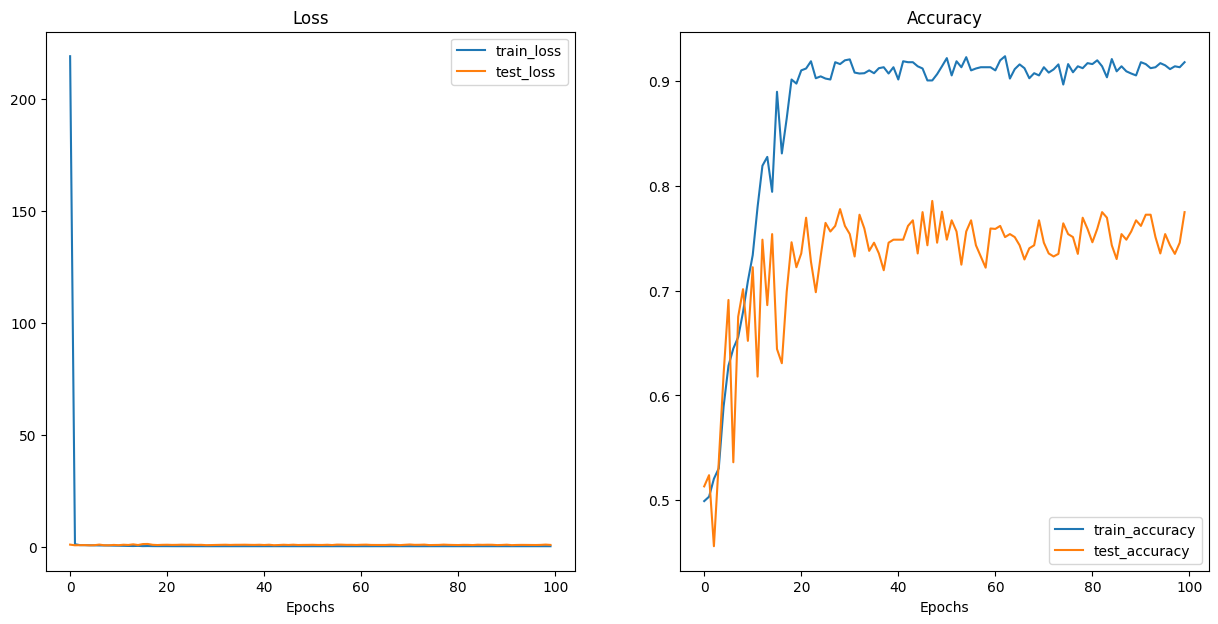

In [39]:
plot_loss_curves(model_0_results)

In [40]:
model_0.state_dict()

OrderedDict([('conv1.0.weight',
              tensor([[[[ 0.3823,  0.4150],
                        [-0.1171,  0.4593]]],
              
              
                      [[[-0.1096,  0.1009],
                        [-0.2434,  0.2936]]],
              
              
                      [[[ 0.4408, -0.3668],
                        [ 0.4346,  0.0936]]],
              
              
                      [[[ 0.3694,  0.0677],
                        [ 0.2411, -0.0706]]],
              
              
                      [[[ 0.3854,  0.0739],
                        [-0.2334,  0.1274]]],
              
              
                      [[[-0.2304, -0.0586],
                        [-0.2031,  0.3317]]],
              
              
                      [[[-0.3947, -0.2305],
                        [-0.1412, -0.3006]]],
              
              
                      [[[ 0.0472, -0.4938],
                        [ 0.4516, -0.4247]]],
              
              
        

In [41]:
# save model
torch.save(model_0.state_dict(), "model_0_state.pth")
print("Trained model saved at model_0_state.pth")

Trained model saved at model_0_state.pth
